# Ask

We have limited data on these merchants and their transactions, but we are still interested in understanding their payments activity to try to infer the types of merchants using our services. Using only the given data, how would you identify different kinds of businesses in the sample? Please generate assignments for each merchant

# Approach

There are a few different approaches one can take here. The first and most obvious is to assign merchants to predefined categories based on experience and intuition, segmenting our population based on empirically derived thresholds for transaction volume, count, average amount, and frequency. This approach however is static, is limited to our understanding of platform dynamics, doesn't surface emergent behavior, or adapt to merchants and the platform growing and evolving.

A better approach is to use unsupervised learning - where we provide an algorithm, KMeans in this case, with massaged data on how different merchants are using our platform, and the algorithm seperates them into clusters based on the distance between them in n-dimensional space. We provide the number of clusters we think exist based on preliminary exploration, and merchants are allocated to a cluster appropriately. Different types of behavior are surfaced, and running the algorithm every few months can help us stay on top of how these behvaiors change. We'll implement this below.

It should be noted that there are limitations to this approach too, and a different tack should be taken for different use cases. We'll discuss this below as well.

# Setup

## Installs and Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lib.visualization import format_plot
from lib.feature_engineering import assign_rank
from lib.clustering import scale_standard, reduce_tsne, cluster_KMeans

## Config

### I/O

In [2]:
DATA_DIR = 'data/'
DATA_FILE = 'data_cleaned.csv'
OUT_DIR = 'output/'
OUTFILE = "merchant_types.csv"

### Modeling

In [3]:
RANDOM_SEED = 42
NUM_CLUSTERS_ROUND_1 = 5
NUM_CLUSTERS_ROUND_2 = 4

### Visualization

In [4]:
# Tabular
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

# Plots
plt.rcParams['figure.figsize'] = [15, 8]

# Warnings
import warnings; warnings.filterwarnings(action='ignore')

# Read in Data

In [5]:
data = pd.read_csv(DATA_DIR + DATA_FILE)
print(f"Dimensions: {data.shape}")
data.head()

Dimensions: (1513501, 4)


,merchant,time,amount,time_diff_days
0,0002b63b92,2033-05-16 20:07:57,33.79,NaN
1,0002d07bba,2034-10-11 17:02:26,55.49,NaN
2,0002d07bba,2034-10-17 17:57:32,378.30,6.04
3,0002d07bba,2034-11-13 15:42:55,438.42,26.91
4,0002d07bba,2034-12-15 09:56:19,20.57,31.76


# Preprocessing

We'll generate merchant level statistics around total transaction volume, transaction count, average amount, standard deviation, and frequency. We'll also add a column for the number of days since the last transaction, should we need to filter out or identify merchants who are no longer active on the platform.

In [6]:
data['time'] = pd.to_datetime(data['time'])
data.sort_values(by=['merchant', 'time'], inplace=True)

merchant_metrics = data.groupby('merchant').agg({
    'amount': ['sum', 'count', 'mean', 'median', 'std'],
    'time_diff_days': ['mean', 'std'],
    'time': [lambda x: round((data['time'].max() - x.max()).total_seconds() / (3600 * 24), 1)]
}).reset_index()

merchant_metrics.columns = ['merchant', 
                            'total_tx_volume', 
                            'tx_count', 
                            'avg_tx_amount', 
                            'median_tx_amount', 
                            'std_tx_amount', 
                            'avg_tx_freq', 
                            'std_tx_freq', 
                            'days_since_last_tx']

print(merchant_metrics.shape)
merchant_metrics.head()

(14351, 9)


,merchant,total_tx_volume,tx_count,avg_tx_amount,median_tx_amount,std_tx_amount,avg_tx_freq,std_tx_freq,days_since_last_tx
0,0002b63b92,33.79,1,33.790000,33.790,NaN,NaN,NaN,593.5
1,0002d07bba,892.78,4,223.195000,216.895,215.685898,21.570000,13.666247,15.9
2,00057d4302,295.21,28,10.543214,7.520,7.807039,2.448148,12.670992,514.1
3,000bcff341,78.26,1,78.260000,78.260,NaN,NaN,NaN,508.5
4,000ddbf0ca,102.99,1,102.990000,102.990,NaN,NaN,NaN,576.8


Merchants with a single transaction have null values for standard deviation and transaction frequencies. We'll set the standard deviation columns to 0, and the average transaction frequency to the max value in the dataset so that things are directionally correct.

In [7]:
merchant_metrics['std_tx_amount'].fillna(0, inplace=True)
merchant_metrics['std_tx_freq'].fillna(0, inplace=True)
merchant_metrics['avg_tx_freq'].fillna(merchant_metrics['avg_tx_freq'].max(), inplace=True)

# Clustering

**We're explicitly removing the `days_since_last_tx` and not adding other indicators of the business' health on the platform (e.g., trends in transaction volume over time). While the health of a merchant is an important indicator of churn and will be used later, it doesn't tell us much about the type of business**

We'll scale the data so that the distance measurement isn't thrown off.

In [8]:
X = merchant_metrics.drop(['merchant', 'days_since_last_tx'], axis=1)
X_scaled = scale_standard(X)

### Estimate number of clusters

We'll use t-SNE, a dimensionality reduction algorithm, to visualize latent clusters in our data. It works especially well for non linear relationships. Given the small size of our dataset, it's computational complexity is not an issue. We could also have used PCA given the relative simplicity of our data, but it struggles to capture complexity as well as t-SNE.

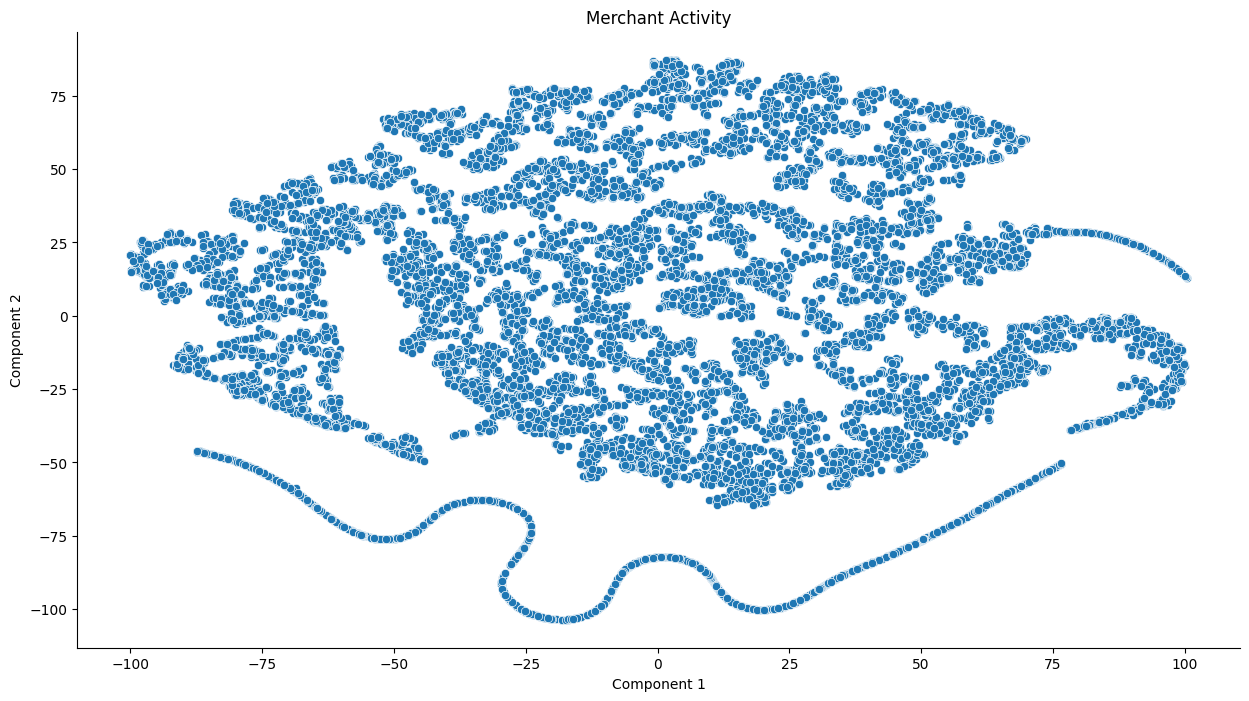

In [9]:
clustered_data_tsne = reduce_tsne(X_scaled, 2, RANDOM_SEED)

sns.scatterplot(x='t-SNE1', y='t-SNE2', data=clustered_data_tsne)
format_plot('Merchant Activity', 'Component 1', 'Component 2')

There appear to be 4-5 clusters, in experimenting with both values, setting `NUM_CLUSTERS = 5` yields the best results

### Create Clusters and Assign Merchants

cluster
1    11488
3     1691
4     1040
0      128
2        4
Name: count, dtype: int64


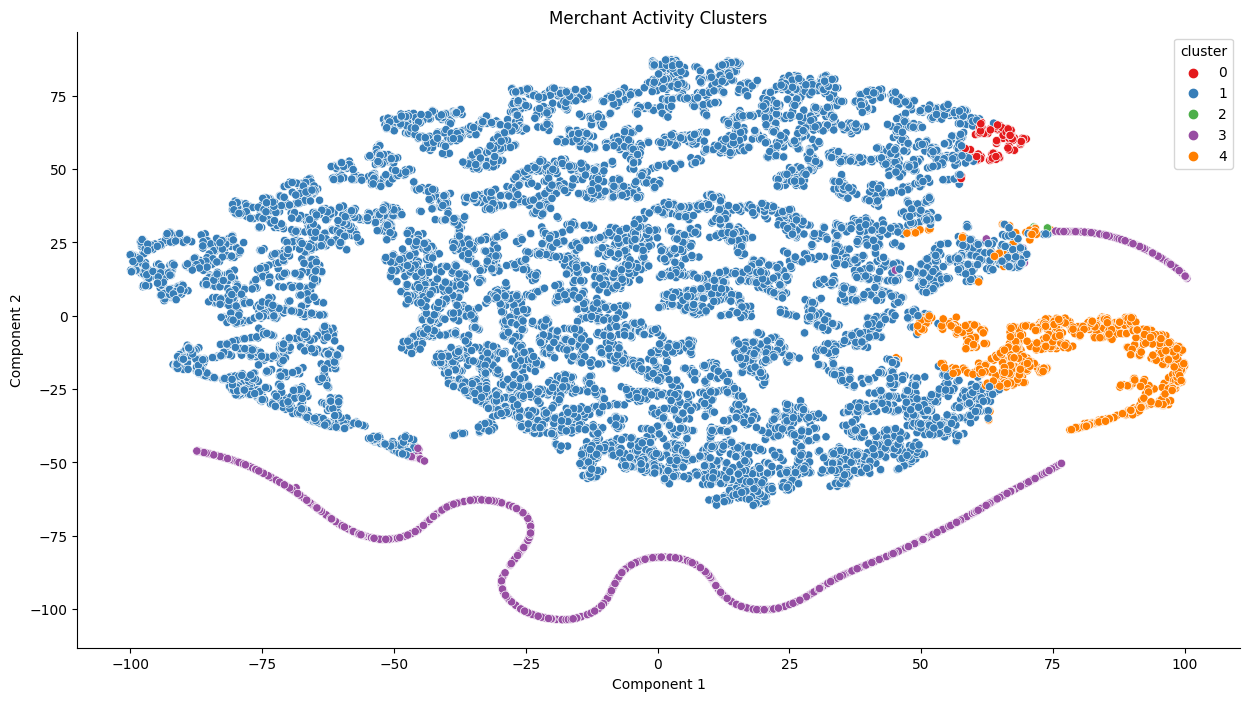

In [10]:
labels = cluster_KMeans(X_scaled, NUM_CLUSTERS_ROUND_1, RANDOM_SEED)
merchant_metrics['cluster'] = labels
print(merchant_metrics['cluster'].value_counts())

clustered_data_tsne['cluster'] = labels
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='cluster', data=clustered_data_tsne, palette='Set1')
format_plot('Merchant Activity Clusters', 'Component 1', 'Component 2')

### Clusters

#### Round 1

The KMeans algorithm seems to have picked up on different clusters of activity, though there's still a large, indeterminate blob in the center. Increasing the number of clusters doesn't help, since the difference between the already separate values is greater than the differences between the central cluster. 

We'll address this later, for now let's understand the clusters that have been identified. 

**Cluster 2 - High End - (Low Frequency + High Tx Amount)**

These appear to be 4 merchants who have a small number of very high value transactions. It's somewhat possible these are test accounts, so it would be good to check to make sure

In [11]:
merchant_metrics[merchant_metrics['cluster'] == 2]

,merchant,total_tx_volume,tx_count,avg_tx_amount,median_tx_amount,std_tx_amount,avg_tx_freq,std_tx_freq,days_since_last_tx,cluster
450,0838e4078e,263459.53,3,87819.843333,2193.730,148422.008642,48.555000,14.828029,148.5,2
2148,26f51e4c7e,110520.25,4,27630.062500,20545.625,30967.781946,13.696667,22.136929,163.6,2
3693,42229128c1,40475.21,1,40475.210000,40475.210,0.000000,724.700000,0.000000,562.7,2
10370,b993083163,533247.91,6,88874.651667,85706.435,8654.541267,19.382000,29.656766,3.6,2


**Cluster 0 - Very High Volume (High Frequency + Average Tx Amount)** 

~130 merchants who have a large number of transactions, in the thousands of average amounts

In [12]:
merchant_metrics[merchant_metrics['cluster'] == 0][:5]

,merchant,total_tx_volume,tx_count,avg_tx_amount,median_tx_amount,std_tx_amount,avg_tx_freq,std_tx_freq,days_since_last_tx,cluster
19,00575c7901,679357.27,9860,68.900332,53.820,56.251696,0.036344,0.071185,0.1,0
21,005e8bb6fb,988351.70,4821,205.009687,127.510,243.615259,0.107286,1.045096,71.3,0
149,02c9bf7fcd,584763.06,7108,82.268298,75.170,19.345838,0.059748,0.119368,65.1,0
236,042cf1e451,380974.67,1218,312.787085,112.760,471.036977,0.470756,0.675015,0.2,0
390,06fe79e266,107430.12,3800,28.271084,21.655,38.331939,0.100711,0.202484,0.4,0


**Cluster 4 - Very Low Volume (Low Frequency + Low/Average Tx Count)** 

~1000 merchants with a low number of transactions, that go weeks and more often months, between transactions

In [13]:
merchant_metrics[merchant_metrics['cluster'] == 4][:5]

,merchant,total_tx_volume,tx_count,avg_tx_amount,median_tx_amount,std_tx_amount,avg_tx_freq,std_tx_freq,days_since_last_tx,cluster
40,00c1ce3556,4010.61,33,121.533636,87.31,73.172395,18.74875,68.296207,2.5,4
42,00cd72cf0e,3305.49,9,367.276667,240.32,259.176909,73.50250,79.949686,60.5,4
66,01422c116f,956.52,5,191.304000,185.69,103.753971,110.23250,123.673991,23.6,4
77,0155692eb6,15.89,7,2.270000,2.24,0.164317,99.35500,122.643378,11.4,4
80,015f6dc983,831.84,13,63.987692,35.15,66.202097,28.48750,88.011143,226.7,4


**Cluster 3 - Single Tx Merchants** 

~1700 merchants with a single transaction - some of these may be test accounts, though the transaction amounts don't seem inorganic in comparison to the rest of the data

In [14]:
merchant_metrics[merchant_metrics['cluster'] == 3][:5]

,merchant,total_tx_volume,tx_count,avg_tx_amount,median_tx_amount,std_tx_amount,avg_tx_freq,std_tx_freq,days_since_last_tx,cluster
0,0002b63b92,33.79,1,33.79,33.79,0.0,724.7,0.0,593.5,3
3,000bcff341,78.26,1,78.26,78.26,0.0,724.7,0.0,508.5,3
4,000ddbf0ca,102.99,1,102.99,102.99,0.0,724.7,0.0,576.8,3
7,001f7b7a4f,64.44,1,64.44,64.44,0.0,724.7,0.0,303.5,3
22,00607c6461,500.94,1,500.94,500.94,0.0,724.7,0.0,9.7,3


**Cluster 1 - Middle of the Pack Merchants** 

This appears to be the catchall for all ~11,000 merchants who tend toward the mean along most dimensions.

In [15]:
merchant_metrics[merchant_metrics['cluster'] == 1][:5]

,merchant,total_tx_volume,tx_count,avg_tx_amount,median_tx_amount,std_tx_amount,avg_tx_freq,std_tx_freq,days_since_last_tx,cluster
1,0002d07bba,892.78,4,223.195000,216.895,215.685898,21.570000,13.666247,15.9,1
2,00057d4302,295.21,28,10.543214,7.520,7.807039,2.448148,12.670992,514.1,1
5,000ed1585f,16472.67,62,265.688226,283.120,60.206112,10.754426,15.096136,24.7,1
6,000f8c3297,34551.91,290,119.144517,67.620,104.836086,1.580484,2.584095,0.7,1
8,0020aefbd9,130.04,2,65.020000,65.020,41.196041,22.660000,0.000000,191.8,1


#### Round 2

Let's see if we can break up this cluster further. We'll rescale the data, and run another round of clustering

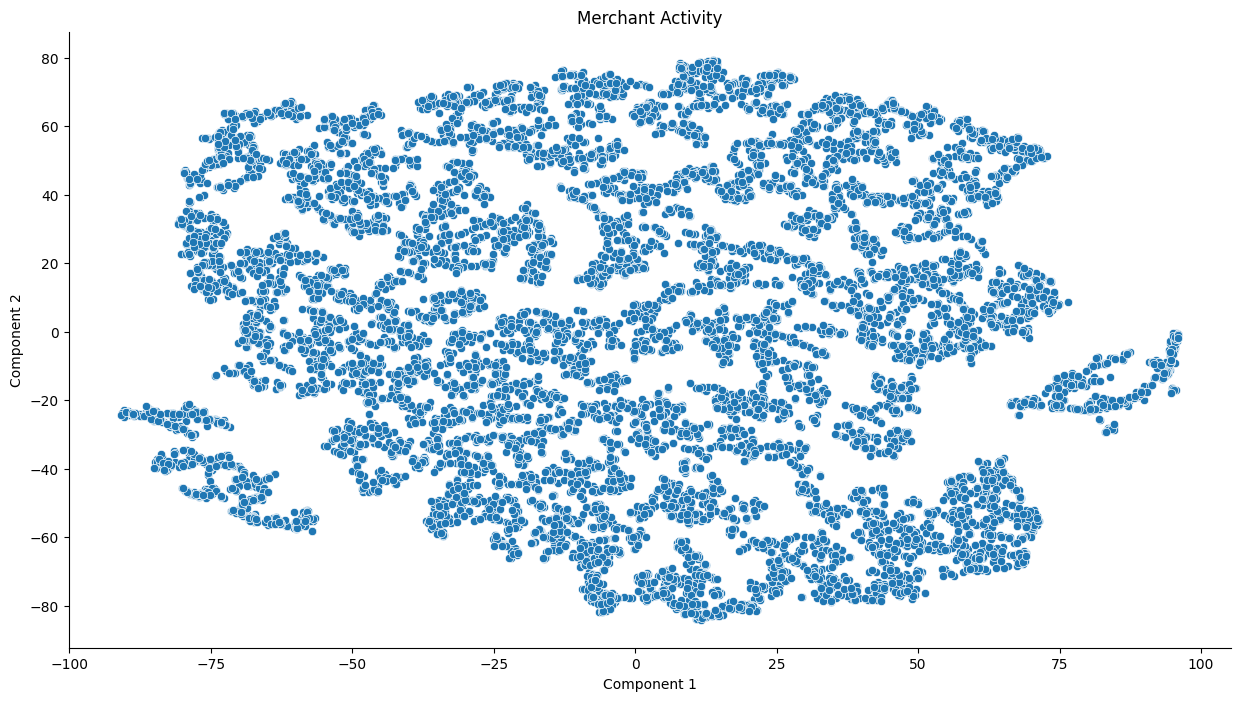

In [16]:
X_sub = merchant_metrics[merchant_metrics['cluster'] == 1].drop(['merchant', 'days_since_last_tx'], axis=1)
X_scaled_sub = scale_standard(X_sub)
clustered_data_tsne_sub = reduce_tsne(X_scaled_sub, 2, RANDOM_SEED)

sns.scatterplot(x='t-SNE1', y='t-SNE2', data=clustered_data_tsne_sub)
format_plot('Merchant Activity', 'Component 1', 'Component 2')

The clusters are harder to see, but 4-5 seem to be a good bet again. We'll set it to `4`.

cluster_sub
1    8078
3    2378
2     545
0     487
Name: count, dtype: int64


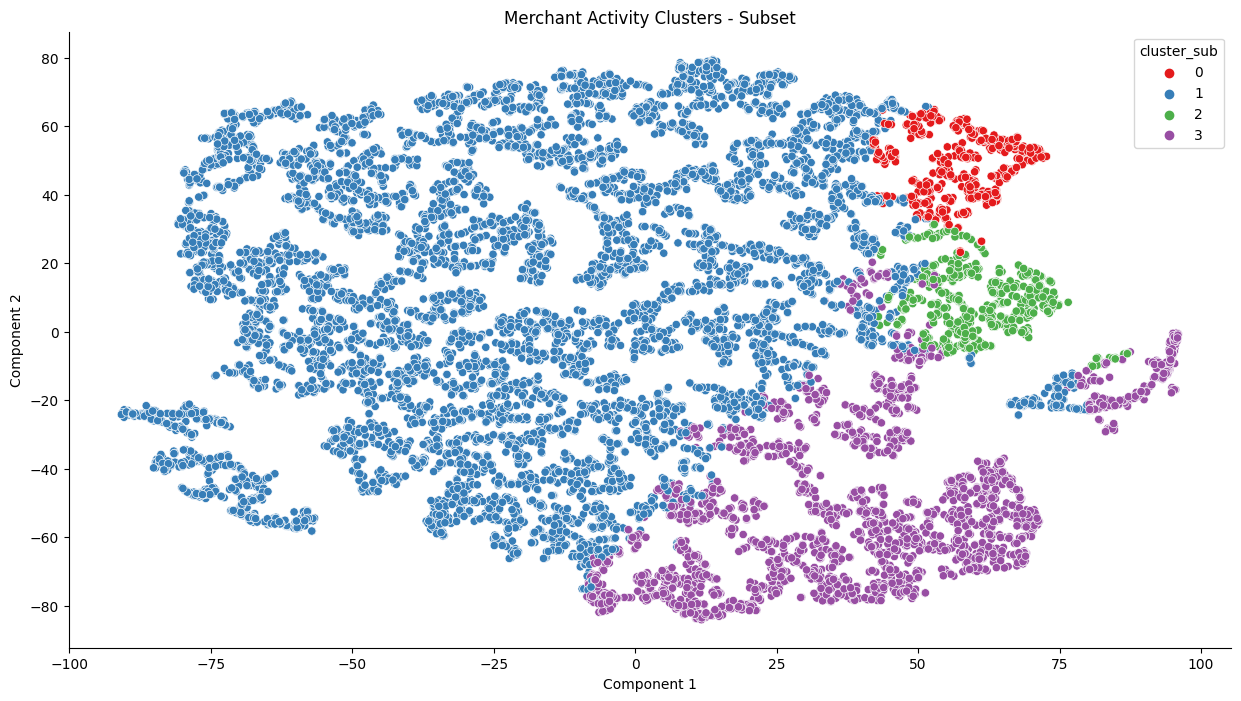

In [17]:
labels_sub = cluster_KMeans(X_scaled_sub, NUM_CLUSTERS_ROUND_2, RANDOM_SEED)
merchant_metrics_sub = merchant_metrics[merchant_metrics['cluster'] == 1]
merchant_metrics_sub['cluster_sub'] = labels_sub
print(merchant_metrics_sub['cluster_sub'].value_counts())

clustered_data_tsne_sub['cluster_sub'] = labels_sub
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='cluster_sub', data=clustered_data_tsne_sub, palette='Set1')
format_plot('Merchant Activity Clusters - Subset', 'Component 1', 'Component 2')

**Cluster 0 - High Volume/High Frequency (High Tx Count + Low/Avg Tx Amount)**

~500 merchants who have a high number of frequent, average sized transactions, resulting in high volume

In [18]:
merchant_metrics_sub[merchant_metrics_sub['cluster_sub'] == 0][:5]

,merchant,total_tx_volume,tx_count,avg_tx_amount,median_tx_amount,std_tx_amount,avg_tx_freq,std_tx_freq,days_since_last_tx,cluster,cluster_sub
64,013a169f1e,62074.25,1003,61.888584,50.32,42.764971,0.317635,1.530374,63.9,1,0
102,01ccc9e43b,64297.67,1182,54.397352,47.06,31.836712,0.321956,2.113675,29.7,1,0
115,0221b4736b,119334.06,2398,49.763995,43.52,26.573689,0.195307,3.646097,48.4,1,0
144,02b9d7abce,37569.21,963,39.012679,17.90,65.961653,0.499304,1.490997,0.5,1,0
204,039fb73850,137737.53,358,384.741704,205.47,554.198520,1.994314,2.368252,0.5,1,0


**Cluster 2 - High Volume/Low Frequency (Low Tx Count + High Tx Amount)**

~500 merchants with a smaller number of larger transactions occurring less frequently, also resulting in a relatively high transaction volume

In [19]:
merchant_metrics_sub[merchant_metrics_sub['cluster_sub'] == 2][:5]

,merchant,total_tx_volume,tx_count,avg_tx_amount,median_tx_amount,std_tx_amount,avg_tx_freq,std_tx_freq,days_since_last_tx,cluster,cluster_sub
30,008a9c02f1,14811.02,6,2468.503333,2446.580,53.700980,24.804000,11.698144,26.0,1,2
62,01335cbe3e,92092.40,39,2361.343590,1344.390,3290.410738,6.870526,10.135999,1.7,1,2
104,01d2ab2ec4,111770.81,43,2599.321163,1246.550,3105.698090,7.618333,8.929633,10.7,1,2
136,0294660a13,120094.95,77,1559.674675,802.130,2907.216768,0.211579,1.078796,225.5,1,2
139,02a42d9d45,58329.93,14,4166.423571,5038.775,2222.829494,29.650769,34.846096,119.0,1,2


**Cluster 3 - Low Volume(Low Tx Count + Low/Avg Tx Amount + Low Freq)**

~2400 merchants with low volume, low transaction count, low transaction frequency, and averaged sized transactions

In [20]:
merchant_metrics_sub[merchant_metrics_sub['cluster_sub'] == 3][:5]

,merchant,total_tx_volume,tx_count,avg_tx_amount,median_tx_amount,std_tx_amount,avg_tx_freq,std_tx_freq,days_since_last_tx,cluster,cluster_sub
11,0037a192b4,951.13,7,135.875714,75.330,182.703831,59.365000,42.142588,101.3,1,3
12,003d24c5d3,677.01,8,84.626250,76.225,36.315904,20.038571,25.988083,21.4,1,3
23,0063ff0c6b,10961.74,28,391.490714,175.825,635.620846,17.743704,59.411176,41.2,1,3
25,007364b02a,608.80,3,202.933333,201.970,1.668542,118.050000,22.613275,416.6,1,3
27,0084eddcc7,30.84,4,7.710000,7.835,2.750309,36.280000,50.530042,13.9,1,3


**Cluster 4 - Middle of the Road**

~8000 merchants converging toward the mean. Additional data points such as the product category, region etc. would help us segment this population further.

In [21]:
merchant_metrics_sub[merchant_metrics_sub['cluster_sub'] == 1][:5] 

,merchant,total_tx_volume,tx_count,avg_tx_amount,median_tx_amount,std_tx_amount,avg_tx_freq,std_tx_freq,days_since_last_tx,cluster,cluster_sub
1,0002d07bba,892.78,4,223.195000,216.895,215.685898,21.570000,13.666247,15.9,1,1
2,00057d4302,295.21,28,10.543214,7.520,7.807039,2.448148,12.670992,514.1,1,1
5,000ed1585f,16472.67,62,265.688226,283.120,60.206112,10.754426,15.096136,24.7,1,1
6,000f8c3297,34551.91,290,119.144517,67.620,104.836086,1.580484,2.584095,0.7,1,1
8,0020aefbd9,130.04,2,65.020000,65.020,41.196041,22.660000,0.000000,191.8,1,1


#### Combination

We can combine the two rounds to come up with a single mapping to 8 clusters

In [22]:
cluster_mapping = {
    0: 'Very High Volume',
    2: 'High End',
    3: 'Single Tx',
    4: 'Very Low Volume',
    5: 'High Vol: Low Tx Amount + High Freq',
    6: 'Average',
    7: 'High Vol: High Tx Amount + Low Freq',
    8: 'Low Volume'
}

In [23]:
merchant_metrics = merchant_metrics.merge(merchant_metrics_sub[['merchant', 'cluster_sub']], on='merchant', how='left')
merchant_metrics['final_cluster'] = np.where(merchant_metrics['cluster_sub'].isnull(), merchant_metrics['cluster'], merchant_metrics['cluster_sub'] + NUM_CLUSTERS_ROUND_1)
merchant_metrics['category'] = merchant_metrics['final_cluster'].map(cluster_mapping)
merchant_metrics['category'].value_counts()

category
Average                                8078
Low Volume                             2378
Single Tx                              1691
Very Low Volume                        1040
High Vol: High Tx Amount + Low Freq     545
High Vol: Low Tx Amount + High Freq     487
Very High Volume                        128
High End                                  4
Name: count, dtype: int64

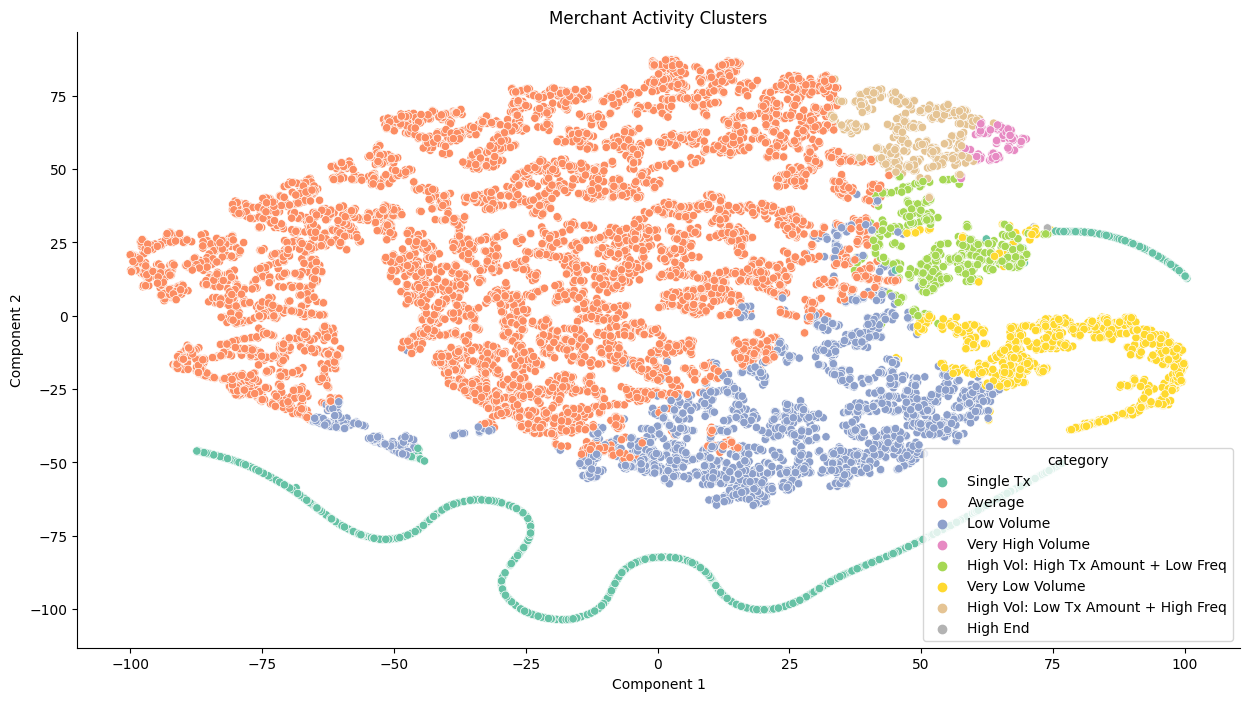

In [24]:
plt.rcParams['figure.figsize'] = [15, 8]
clustered_data_tsne['final_cluster'] = merchant_metrics['final_cluster']   
clustered_data_tsne['category'] = merchant_metrics['category'] 
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='category', data=clustered_data_tsne, palette='Set2')
format_plot('Merchant Activity Clusters', 'Component 1', 'Component 2')

#### Categories

In [25]:
mmr = assign_rank(merchant_metrics, ['total_tx_volume', 'tx_count', 'avg_tx_amount'])
mmr = assign_rank(merchant_metrics, ['avg_tx_freq'], ascending=False)

cluster_metrics = merchant_metrics.groupby('category').agg({
    'total_tx_volume_rank': ['mean'],
    'tx_count_rank': ['mean'],
    'avg_tx_amount_rank': ['mean'],
    'avg_tx_freq_rank': ['mean'],
}).reset_index()

cluster_metrics.columns = ['category', 
                           'tx_volume', 
                           'tx_count', 
                           'tx_amount',
                           'tx_freq']

print(cluster_metrics.shape)
cluster_metrics

(8, 5)


,category,tx_volume,tx_count,tx_amount,tx_freq
0,Average,52.644714,57.881208,44.867504,66.162355
1,High End,96.800000,24.050000,100.000000,27.400000
2,High Vol: High Tx Amount + Low Freq,84.760550,47.152294,96.784037,39.833761
3,High Vol: Low Tx Amount + High Freq,96.361396,96.527721,54.896509,89.143943
4,Low Volume,45.545332,47.295585,49.746972,31.491043
5,Single Tx,19.779953,5.959669,56.785985,5.892076
6,Very High Volume,99.133594,98.918750,50.557031,94.206250
7,Very Low Volume,42.675096,40.295962,52.387981,20.175577


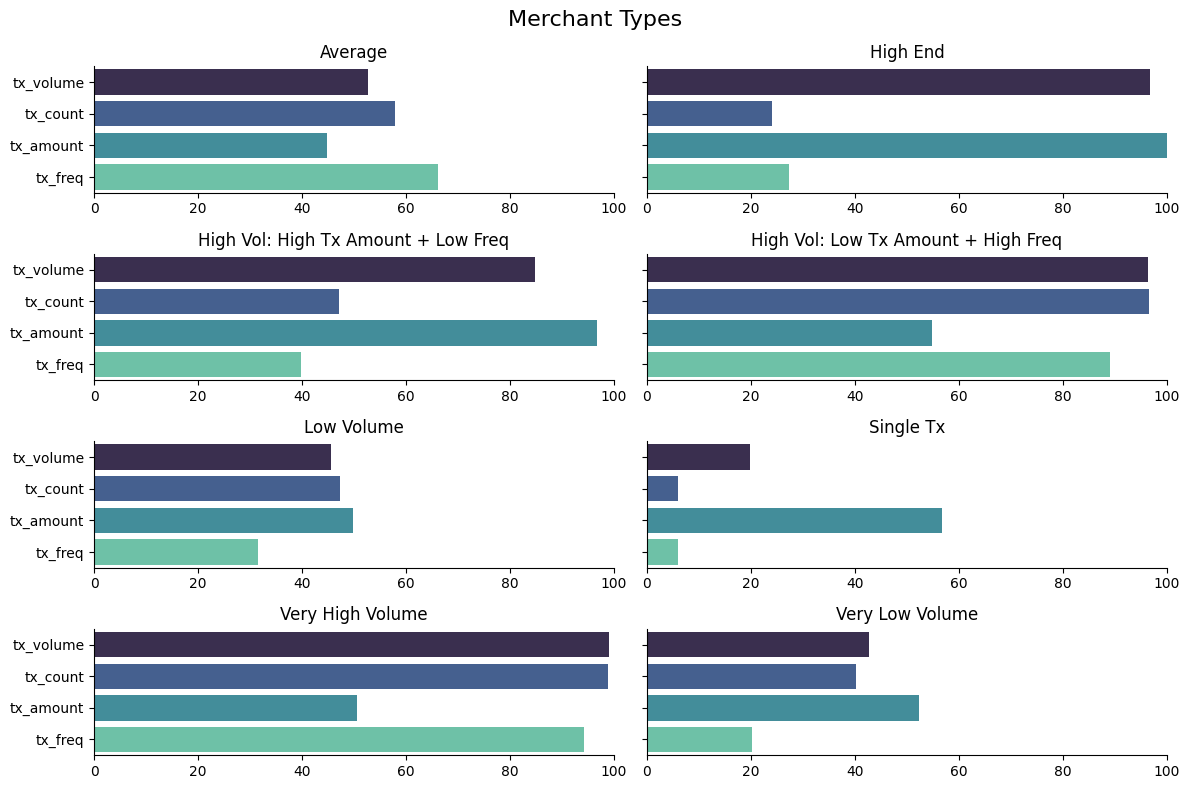

In [26]:
fig, axes = plt.subplots(4, 2, figsize=(12, 8), sharey=True)
axes = axes.flatten()
x_axis_limits = (0, 100)

for i, c in enumerate(cluster_metrics['category'].unique()):
    data = cluster_metrics[cluster_metrics['category'] == c].drop('category', axis=1)
    sns.barplot(data=data, orient="h", palette="mako", ax=axes[i]) 
    axes[i].set_xlim(x_axis_limits)
    ax=axes[i].set_title(f'{c}')
    sns.despine()

plt.suptitle("Merchant Types", fontsize=16)
plt.tight_layout()
plt.show()

### Usage

We can use these clusters to understand existing usage patterns and isolate emergent behavior. This understanding can help define our product strategy - maybe we're not building for, or actively harming the experience of a certain type of merchant; maybe there's an opportunity for us to launch a new feature catering to an underserved, but important, growing niche.

The size of these clusters can also help us prioritize our efforts - without data such as this, we may overestimate the prevalence of certain types of merchants, while ignoring a silent but large cohort that needs different things.

Given that unsupervised learning requires manual interpretation, designing fully automated pipelines is difficult. That said, processes should be designed and data pipelines built to ensure that this type of analysis happens every quarter.

### Shortcomings

Unsupervised Learning is primarily an exploratory exercise - it tells us about the contours of the space under investigation, but doesn't give us precise results or weights that can be used to assess how valuable a merchant is to the platform. It also isn't currently taking the health of the merchant on the platform into account, as that wasn't the purpose of this exercise.

If we want to go beyond just understanding the different types of merchants, and assign a value to them so that we can assess the ongoing health/profitability of our platform, and the impact of any changes we make, we will have to follow a more deterministic, interpretable approach, that also takes the trajectory of the merchant's activity into account. 

## Write

In [27]:
# mmr[['merchant', 'category']].to_csv(OUT_DIR + OUTFILE, index=False)

# Addendum - Merchant Value

While this is outside the scope of this exercise, each merchant can be assigned a weighted score meant to represent their value to our platform. One such example could be:

**(0.5 * Volume_Rank) + (0.2 * 3_Month_Tx_Volume_Change) + (0.15 * Avg_Tx_Amount) + (0.15 * Avg_Tx_Frequency)**

Where the:
- volume rank represents the share of revenue they're responsible for
- change in volume their prospects (a quick proxy for lifetime value)
- average transaction amount a sense of unit economics
- average transaction frequency a measure of revenue from per transaction fees

This can be done at the end of each period, only for active merchants.

This approach is deterministic, interpretable, easy to understand, and reproduce, and complements the unsupervised approach above nicely. We can even intersect the clusters above with the importance ranks of the merchants within the cluster to help us decide what section of user base to focus on from a product perspective.